In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Setup
base_dir = 'food'
image_size = (224, 224)
batch_size = 32
num_classes = 100

# Preprocessing sesuai MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Simpan urutan label
label_map = train_generator.class_indices
class_names = list(label_map.keys())

# Load pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Unfreeze 30 lapisan terakhir saja
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# Save model
model.save('final_mobilenetv2_food_finetune_100.keras')

Found 39680 images belonging to 100 classes.
Found 9920 images belonging to 100 classes.
Epoch 1/100


c:\Users\Faqih SA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1240/1240 ━━━━━━━━━━━━━━━━━━━━ 840s 671ms/step - accuracy: 0.0140 - loss: 4.9657 - val_accuracy: 0.0745 - val_loss: 4.3369
Epoch 2/100
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 565s 454ms/step - accuracy: 0.0511 - loss: 4.4374 - val_accuracy: 0.1749 - val_loss: 3.8973
Epoch 3/100
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 565s 454ms/step - accuracy: 0.1191 - loss: 4.0561 - val_accuracy: 0.2541 - val_loss: 3.4952
Epoch 4/100
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 564s 454ms/step - accuracy: 0.1781 - loss: 3.7308 - val_accuracy: 0.3211 - val_loss: 3.1660
Epoch 5/100
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 565s 454ms/step - accuracy: 0.2287 - loss: 3.4442 - val_accuracy: 0.3674 - val_loss: 2.8767
Epoch 6/100
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 565s 455ms/step - accuracy: 0.2671 - loss: 3.2212 - val_accuracy: 0.4114 - val_loss: 2.6417
Epoch 7/100
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 567s 456ms/step - accuracy: 0.3116 - loss: 3.0055 - val_accuracy: 0.4437 - val_loss: 2.4565
Epoch 8/100
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 567s 456ms/step - accura

In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,441,582 (24.57 MB)

 Trainable params: 1,902,372 (7.26 MB)

 Non-trainable params: 734,464 (2.80 MB)

 Optimizer params: 3,804,746 (14.51 MB)

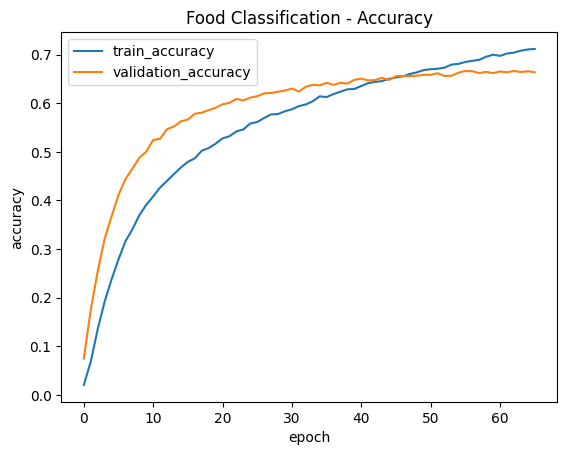

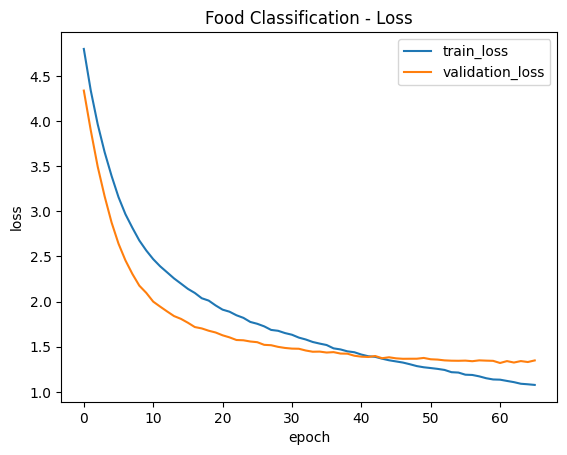

In [4]:
def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

# Memvisualisasikan grafik akurasi dan loss dari history pelatihan model
plot_accuracy(history, 'Food Classification - Accuracy')
plot_loss(history, 'Food Classification - Loss')

In [5]:
# Langkah 1: Menggunakan data validasi penuh untuk evaluasi
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    shuffle=False  # Jangan acak agar urutan data tetap untuk evaluasi
)

# Memuat model yang sudah disimpan
model = load_model('final_mobilenetv2_food_finetune_100.keras')

# Melakukan prediksi pada seluruh data validasi
val_steps = validation_generator.samples // batch_size + 1
predictions = model.predict(validation_generator, steps=val_steps)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = validation_generator.classes

# Cek jumlah kelas pada data validasi
num_classes_val = len(np.unique(true_labels))
print(f"Jumlah kelas pada data validasi: {num_classes_val}")

# Mengambil nama kelas dari generator
class_names = list(validation_generator.class_indices.keys())
print(f"Jumlah kelas yang terbaca oleh validation_generator: {len(class_names)}")

# hitung akurasi
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Akurasi model: {accuracy * 100:.2f}%')

# Menghitung classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Menampilkan seluruh baris pada dataframe
pd.set_option('display.max_rows', None)

# Menampilkan classification report dalam bentuk tabel
print("Classification Report:")
print(df_report)

Found 9920 images belonging to 100 classes.
311/311 ━━━━━━━━━━━━━━━━━━━━ 103s 329ms/step
Jumlah kelas pada data validasi: 100
Jumlah kelas yang terbaca oleh validation_generator: 100
Akurasi model: 66.24%
Classification Report:
                         precision    recall  f1-score      support
apple_pie                 0.409639  0.340000  0.371585   100.000000
baby_back_ribs            0.653061  0.640000  0.646465   100.000000
baklava                   0.614035  0.700000  0.654206   100.000000
beef_tartare              0.807229  0.670000  0.732240   100.000000
beet_salad                0.505376  0.470000  0.487047   100.000000
beignet                   0.743119  0.810000  0.775120   100.000000
bibimbap                  0.811881  0.820000  0.815920   100.000000
bread_pudding             0.446809  0.420000  0.432990   100.000000
breakfast_burrito         0.525773  0.510000  0.517766   100.000000
bruschetta                0.500000  0.550000  0.523810   100.000000
caesar_salad            

c:\Users\Faqih SA\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


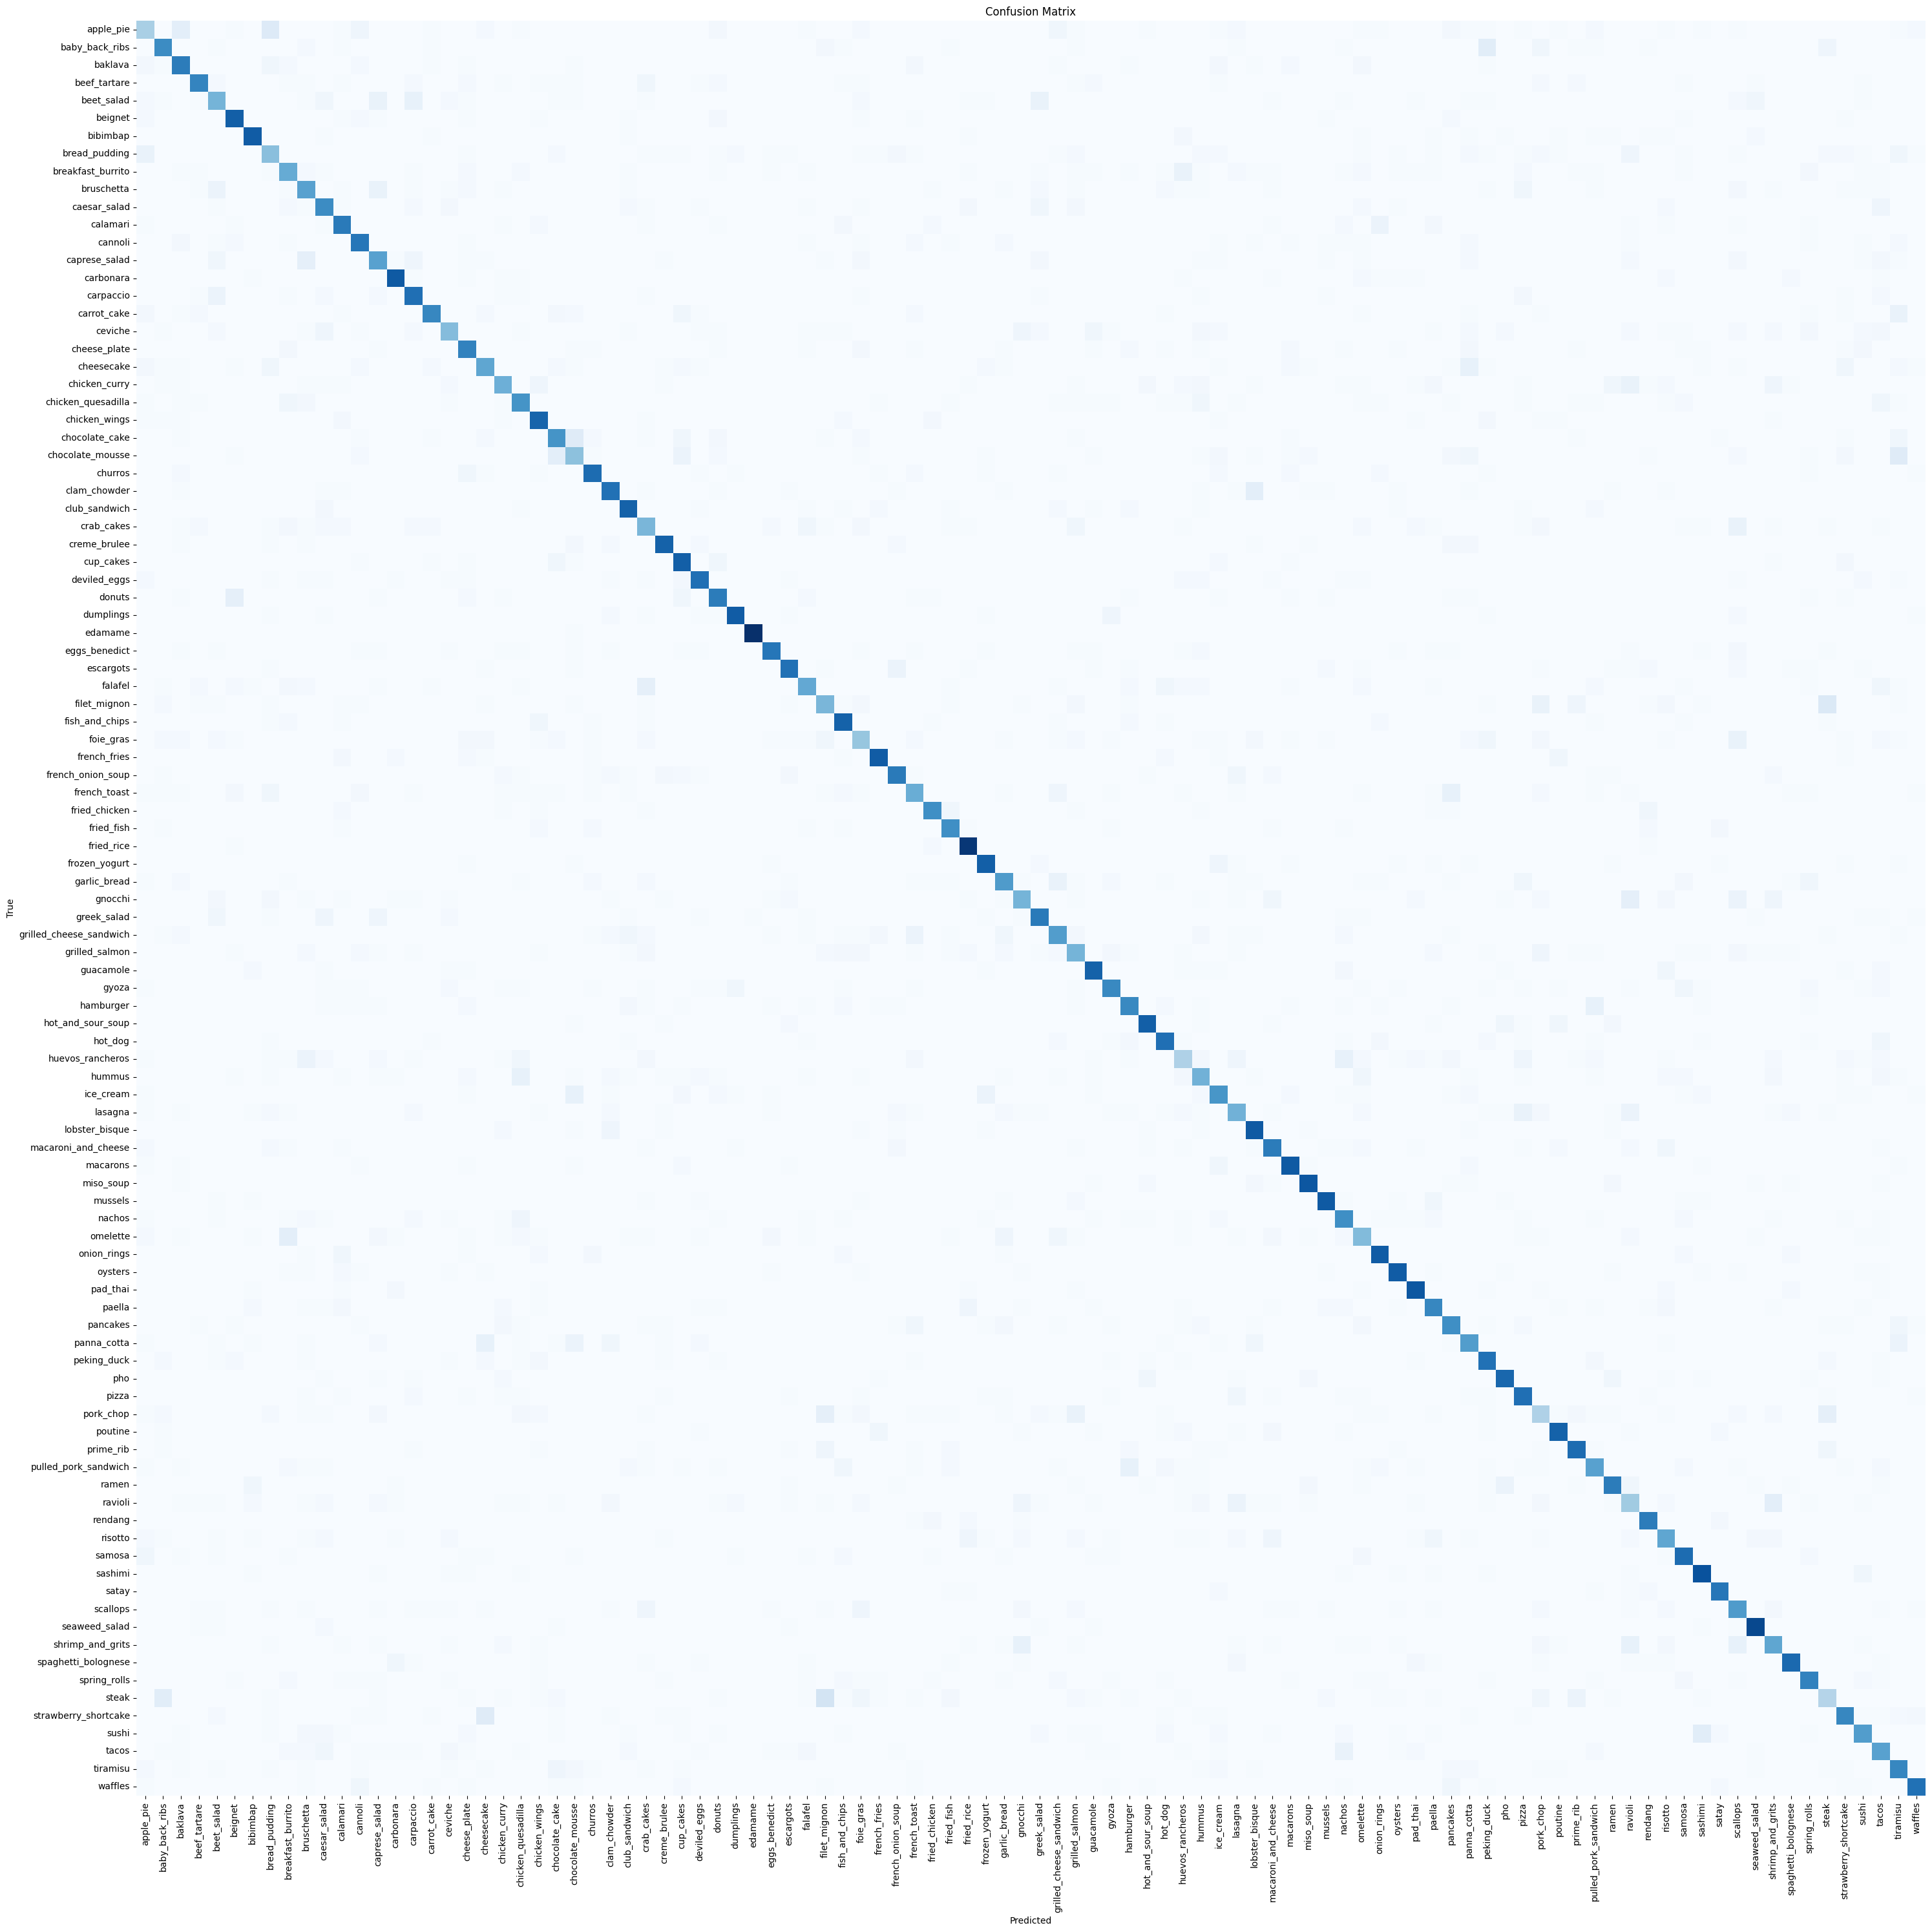

In [6]:
cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(len(class_names)))

plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=False, fmt='g', vmin=0, cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()